# Limpieza del conjunto de datos *ATUS*

En esta *notebook* se documenta el proceso de **limpieza** del conjunto de datos **Accidentes de Tránsito en Zonas Urbanas y Suburbanas (ATUS)**, publicados por el **INEGI**.

Estos datos corresponden a los **accidentes de tránsito con información georreferenciada**, lo que permite analizar su relación espacial con otras variables, como la presencia de baches o el tipo de vialidad.

Aunque el INEGI ofrece un histórico amplio del programa ATUS, únicamente los años **2021, 2022 y 2023** incluyen coordenadas geográficas de los incidentes, por lo que **solo estos tres periodos fueron considerados** para el análisis.

El propósito es **filtrar, estandarizar y preparar** la información geoespacial de los accidentes de tránsito en Hermosillo, asegurando su compatibilidad con otras fuentes de datos municipales (como *colonias*, *vialidades* y *clima*), con el fin de obtener un conjunto *tidy* listo para análisis y visualización.

Los datos provienen del producto oficial **"Accidentes de Tránsito en Zonas Urbanas y Suburbanas (ATUS)"** publicado por **INEGI**, y fueron descargados directamente mediante el siguiente *script*:

```bash
python src/download_atus.py
```

Posteriormente, los archivos ZIP fueron **extraídos** con:

```bash
python src/extract_atus.py
```

Este flujo genera los archivos *raw* correspondientes a los años 2021–2023, almacenados en la carpeta [`data/raw/atus`](../data/raw/atus/).

# 0. Configuración del entorno 

Importamos las librerías principales: 

In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import missingno as msno

Definimos un ruta a un directorio temporal para almacenar datos en caso de ser necesario: 

In [2]:
temp_dir = Path().resolve().parent / "data" / "temp" / "atus"
temp_dir.mkdir(parents=True, exist_ok=True)

Definimos las rutas de acceso a los datos *raw* del conjunto ATUS: 

In [3]:
root = Path().resolve().parent
data_dir = root / "data"
raw_dir = data_dir / "raw"
atus_dir = raw_dir / "atus"

for item in atus_dir.iterdir(): 
    print(item.relative_to(root))

data\raw\atus\atus_2021_shp
data\raw\atus\atus_2021_shp.zip
data\raw\atus\atus_2022_shp
data\raw\atus\atus_2022_shp.zip
data\raw\atus\atus_2023_shp
data\raw\atus\atus_2023_shp.zip


En el directorio `data/raw/vialidades` se encuentran:

* `atus_x_shp.zip`: Archivo ZIP de los datos para el año `x`

* `atus_x_shp`: Directorio con los datos extraidos de `atus_x_shp.zip`

donde `x={2021, 2022, 2023}`. 


Cada subdirectodrio contiene los archivos geoespaciales (``shapefile`) y de apoyo (metadatos, diccionario de datos) correspondientes a un año en específico. 

```bash
data/
└── raw/
    └── atus/
        ├── atus_x_shp/
        │   ├── conjunto_de_datos/
        │   │   ├── BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2021.shp
        │   │   ├── BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2021.dbf
        │   │   ├── BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2021.shx
        │   │   └── BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2021.prj
        │   ├── diccionario_de_datos/
        │   │   └── fd_bd_atus_georreferenciación.xlsx
        │   └── metadatos/
        │       ├── Metadatos_geográficos_ATUS_2019_2022.txt
        │       └── Metadatos_geográficos_ATUS_2019_2022.xml
        ├── atus_2022_shp/
        ├── atus_2023_shp/
        ├── atus_2021_shp.zip
        ├── atus_2022_shp.zip
        └── atus_2023_shp.zip
```

Cada carpeta `atus_x_shp` (donde `x` indica el año) incluye:

* **`conjunto_de_datos/`** → Archivos del shapefile principal (`.shp`, `.dbf`, `.shx`, `.prj`) y su versión `.csv`.
* **`diccionario_de_datos/`** → Catálogo de variables del conjunto, en formato Excel.
* **`metadatos/`** → Documentos descriptivos del producto, en formato `.txt` y `.xml`.


A partir de esta estructura, definimos las rutas específicas hacia los archivos *shapefile* de cada año, que serán utilizados en el proceso de limpieza y consolidación de los datos:


In [4]:
shp_2021 = atus_dir / "atus_2021_shp" / "ATUS_2021" / "conjunto_de_datos" / "BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2021.shp"
shp_2022 = atus_dir / "atus_2022_shp" / "conjunto_de_datos" / "BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2022.shp"
shp_2023 = atus_dir / "atus_2023_shp" / "conjunto_de_datos" / "BASE MUNICIPAL_ACCIDENTES DE TRANSITO GEORREFERENCIADOS_2023.shp"

Verificamos que las rutas existen y podemos cargar los datos: 

In [5]:
for path in [shp_2021, shp_2022, shp_2023]: 
    print(path.exists(), path.is_file())

True True
True True
True True


De esta forma, se cuenta con las rutas listas para la carga e inspección inicial de los datos geoespaciales correspondientes a los años 2021–2023.

### 0.1 Algunas funciones auxiliares


A continuación se definen algunas funciones auxiliares útiles para explorar el conjunto de datos: 

In [6]:
def add_basemap_to_ax(ax, crs):
    ctx.add_basemap(
        ax, 
        source=ctx.providers.OpenStreetMap.Mapnik, 
        crs=crs.to_string()
    )

## 1. Carga y descripción general

Cargamos los datos usando *GeoPandas*:

In [ ]:
gatus_urbs = [gpd.read_file(path, index_col=0) for path in [shp_2021, shp_2022, shp_2023]]

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from CP1252 to UTF-8. This warning will not be emitted anymore
  return ogr_read(
c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option INDEX_COL
  return ogr_read(
c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from CP1252 to UTF-8. This warning will not be emitted anymore
  return ogr_read(
c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver ESRI Sha

Según el diccionario los datos de cada año, todos los datos poseen la misma estructura, por lo que podemos concatenarlos: 

In [ ]:
atus = pd.concat(gatus_urbs)

Los primeros registros: 

In [9]:
atus.head()

,ID,EDO,MES,ANIO,MPIO,HORA,MINUTOS,DIA,DIASEMANA,URBANA,...,TOTMUERTOS,TOTHERIDOS,CLASE,CALLE1,CALLE2,CARRETERA,LONGITUD,LATITUD,OID,geometry
0,1009255-112-190821532,1,1,2021,1,0,0,1,5,1,...,0,0,3,AGUASCALIENTES ORIENTE,AJONJOLÍ,None,-102.25252,21.86376,1,POINT (-102.25252 21.86376)
1,1009255-112-190821538,1,1,2021,1,0,0,1,5,1,...,0,0,3,PETRÓLEOS MEXICANOS,GENERAL IGNACIO ZARAGOZA,None,-102.29519,21.89120,2,POINT (-102.29519 21.8912)
2,1009255-112-190821641,1,1,2021,1,0,0,1,5,1,...,1,0,1,CONSTITUCIÓN,PASEO DE LA SOLIDARIDAD,None,-102.28652,21.91522,3,POINT (-102.28652 21.91522)
3,1009255-112-190821424,1,1,2021,1,0,0,1,5,1,...,0,1,2,PORFIRIO PADILLA ENRÍQUEZ,None,None,-102.25603,21.92720,4,POINT (-102.25603 21.9272)
4,1009255-112-190821428,1,1,2021,1,0,50,1,5,1,...,0,1,2,CULTURA OTOMÍ 408,CULTURA MAYA,None,-102.24423,21.90958,5,POINT (-102.24423 21.90958)


Información general: 

In [10]:
atus.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 712883 entries, 0 to 262767
Data columns (total 51 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ID          712883 non-null  object  
 1   EDO         712883 non-null  int64   
 2   MES         712883 non-null  int64   
 3   ANIO        712883 non-null  int64   
 4   MPIO        712883 non-null  int64   
 5   HORA        712883 non-null  int64   
 6   MINUTOS     712883 non-null  int64   
 7   DIA         712883 non-null  int64   
 8   DIASEMANA   712883 non-null  int64   
 9   URBANA      712883 non-null  int64   
 10  SUBURBANA   712883 non-null  int64   
 11  TIPACCID    712883 non-null  int64   
 12  AUTOMOVIL   712883 non-null  int64   
 13  CAMPASAJ    712883 non-null  int64   
 14  MICROBUS    712883 non-null  int64   
 15  PASCAMION   712883 non-null  int64   
 16  OMNIBUS     712883 non-null  int64   
 17  TRANVIA     712883 non-null  int64   
 18  CAMIONETA   712883 no

Observamos que el conjunto posee +7e5 registros y 51 columnas. 

La descripción estadística básica: 

In [11]:
atus.describe()

,EDO,MES,ANIO,MPIO,HORA,MINUTOS,DIA,DIASEMANA,URBANA,SUBURBANA,...,CICLMUERTO,CICLHERIDO,OTROMUERTO,OTROHERIDO,TOTMUERTOS,TOTHERIDOS,CLASE,LONGITUD,LATITUD,OID
count,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,...,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000,712883.000000
mean,16.571924,6.684053,2022.089137,32.934302,13.122646,26.278409,15.619769,4.030239,1.069073,0.049472,...,0.000303,0.005638,0.000060,0.000589,0.007963,0.198525,2.837035,-102.095360,23.996379,120415.433363
std,7.706249,3.424948,0.800073,32.854821,5.965122,17.695851,8.815608,1.981253,0.341076,0.313875,...,0.017644,0.077070,0.007766,0.026103,0.098366,0.592627,0.388878,5.626786,3.967735,71172.480229
min,1.000000,1.000000,2021.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-117.123081,14.708967,1.000000
25%,10.000000,4.000000,2021.000000,12.000000,9.000000,10.000000,8.000000,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-104.339765,20.562069,59407.500000
50%,19.000000,7.000000,2022.000000,27.000000,14.000000,27.000000,16.000000,4.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-100.386883,25.556427,118814.000000
75%,21.000000,10.000000,2023.000000,39.000000,18.000000,40.000000,23.000000,6.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,-99.862100,25.784919,178221.000000
max,32.000000,12.000000,2023.000000,385.000000,99.000000,99.000000,32.000000,8.000000,2.000000,3.000000,...,2.000000,4.000000,1.000000,3.000000,12.000000,42.000000,3.000000,-86.742763,32.671594,262768.000000


Los registros nulos: 

In [12]:
atus.isnull().mean().to_dict()

{'ID': 0.0,
 'EDO': 0.0,
 'MES': 0.0,
 'ANIO': 0.0,
 'MPIO': 0.0,
 'HORA': 0.0,
 'MINUTOS': 0.0,
 'DIA': 0.0,
 'DIASEMANA': 0.0,
 'URBANA': 0.0,
 'SUBURBANA': 0.0,
 'TIPACCID': 0.0,
 'AUTOMOVIL': 0.0,
 'CAMPASAJ': 0.0,
 'MICROBUS': 0.0,
 'PASCAMION': 0.0,
 'OMNIBUS': 0.0,
 'TRANVIA': 0.0,
 'CAMIONETA': 0.0,
 'CAMION': 0.0,
 'TRACTOR': 0.0,
 'FERROCARRI': 0.0,
 'MOTOCICLET': 0.0,
 'BICICLETA': 0.0,
 'OTROVEHIC': 0.0,
 'CAUSAACCI': 0.0,
 'CAPAROD': 0.0,
 'SEXO': 0.0,
 'ALIENTO': 0.0,
 'CINTURON': 0.0,
 'EDAD': 0.0,
 'CONDMUERTO': 0.0,
 'CONDHERIDO': 0.0,
 'PASAMUERTO': 0.0,
 'PASAHERIDO': 0.0,
 'PEATMUERTO': 0.0,
 'PEATHERIDO': 0.0,
 'CICLMUERTO': 0.0,
 'CICLHERIDO': 0.0,
 'OTROMUERTO': 0.0,
 'OTROHERIDO': 0.0,
 'TOTMUERTOS': 0.0,
 'TOTHERIDOS': 0.0,
 'CLASE': 0.0,
 'CALLE1': 0.0048703644216512385,
 'CALLE2': 0.031017712583972405,
 'CARRETERA': 0.9741542441045725,
 'LONGITUD': 0.0,
 'LATITUD': 0.0,
 'OID': 0.0,
 'geometry': 0.0}

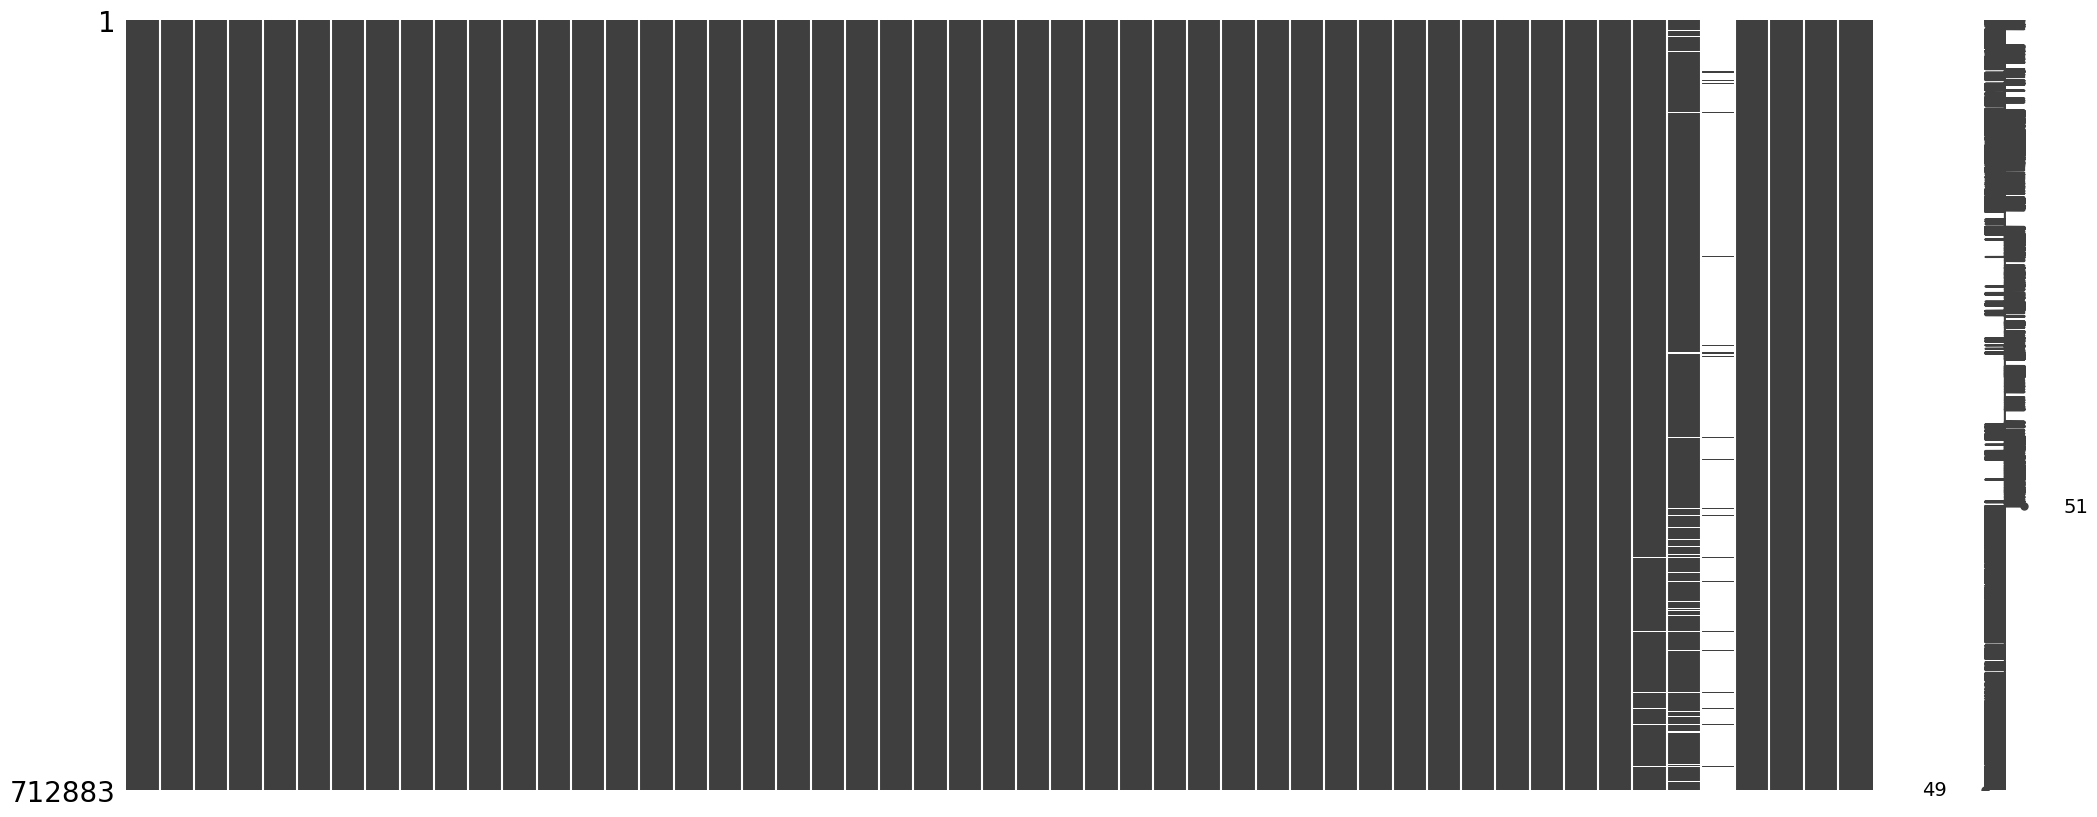

In [13]:
msno.matrix(atus)
plt.show()

Las columnas `CALLE1`, `CALLE2`, `CARRETERA` poseen valores nulos. 

Los tipos de geometrías únicos: 

In [14]:
atus.geom_type.unique()

array(['Point'], dtype=object)

El *csr* (*coordinate reference system*): 

In [15]:
atus.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

El conjunto de datos posee el *crs* estandar usado por la mayoria de aplicaciones web y sistemas GIS: `epgs=4326`

## 2. Exploración y limpieza del conjunto de datos

Las columnas: 

In [16]:
columns = atus.columns.tolist()
columns

['ID',
 'EDO',
 'MES',
 'ANIO',
 'MPIO',
 'HORA',
 'MINUTOS',
 'DIA',
 'DIASEMANA',
 'URBANA',
 'SUBURBANA',
 'TIPACCID',
 'AUTOMOVIL',
 'CAMPASAJ',
 'MICROBUS',
 'PASCAMION',
 'OMNIBUS',
 'TRANVIA',
 'CAMIONETA',
 'CAMION',
 'TRACTOR',
 'FERROCARRI',
 'MOTOCICLET',
 'BICICLETA',
 'OTROVEHIC',
 'CAUSAACCI',
 'CAPAROD',
 'SEXO',
 'ALIENTO',
 'CINTURON',
 'EDAD',
 'CONDMUERTO',
 'CONDHERIDO',
 'PASAMUERTO',
 'PASAHERIDO',
 'PEATMUERTO',
 'PEATHERIDO',
 'CICLMUERTO',
 'CICLHERIDO',
 'OTROMUERTO',
 'OTROHERIDO',
 'TOTMUERTOS',
 'TOTHERIDOS',
 'CLASE',
 'CALLE1',
 'CALLE2',
 'CARRETERA',
 'LONGITUD',
 'LATITUD',
 'OID',
 'geometry']

Normalizamos los nombres de las columnas: 

In [17]:
atus.columns = atus.columns.str.lower()

Actualmente, el conjunto de datos posee información de todos los estados de México. 

La columna `edo` posee el identificador de la entidad federativa: 

In [18]:
atus.edo.unique()

array([ 1,  9, 15,  4,  8,  6,  7, 16, 12, 11, 10, 14, 13,  2,  3,  5, 19,
       25, 28, 29, 21, 18, 23, 30, 26, 24, 22, 17, 32, 31, 20, 27])

La columna `mpio` es el indicador de el municipio: 

In [19]:
atus.mpio.unique()

array([  1,   5,  11,   2,  57, 104,  15,   3,  14,  10,   7,  12,  13,
         4,  16,  17,   6,  58,   8,   9,  19,  20,  25, 122,  39,  33,
        29,  31, 120,  51, 106,  54,  70,  95, 121, 109, 118,  34, 102,
       108,  53,  69, 112,  97,  98, 101,  44,  27,  77,  23,  21,  18,
        35,  30,  78,  89,  38,  46,  26,  41, 119, 114,  28, 193, 140,
        48,  45,  56,  47,  50,  22,  49,  67, 385, 131,  32, 184,  55,
       156,  87,  81,  24,  37,  60,  99,  43, 144])

Actualmente, el conjunto de datos posee información de todos los estados de México. 

Según el [diccionario de datos](../data/raw/atus/atus_2022_shp/diccionario_de_datos/fd_bd_atus_georreferenciación.xlsx), Sonora posee la clave de entidad 26 (`edo=26`) y Hermosillo la clave de municipio 30 (`mpio=30`). 

In [20]:
atus_hmo = atus[(atus['edo'] == 26) & (atus['mpio'] == 30)]

El total de registros en Hermosillo, Sonora: 

In [21]:
len(atus_hmo)

33893

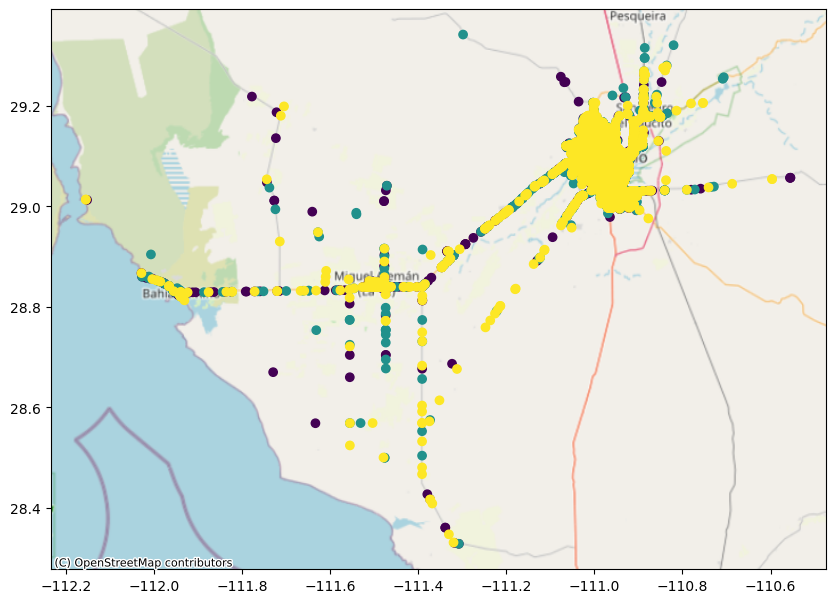

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

atus_hmo.plot('anio', ax=ax)
add_basemap_to_ax(ax, atus_hmo.crs)
plt.show()

Observamos que los datos poseen información de **todo el municipio de Hermosillo**. Por lo que hay que filtrar los datos en la region urbana de Hermosillo. 

Para ello definimos una *boundry box* de la zona urbana con las siguientes coordenadas límite: 

In [24]:
# Coordenadas límite (x = longitudes, y = latitudes)
x_min, x_max = -111.075, -110.900
y_min, y_max = 28.900, 29.200

In [25]:
from shapely.geometry import box

El rectángulo que reprecenta el área urbana de Hermosillo: 

In [26]:
bbox = box(x_min, y_min, x_max, y_max)

Ahora, intersecamos el *boundry box* con las vialidades de Hermosillo: 

In [27]:
atus_urb = atus_hmo[atus_hmo.intersects(bbox)]

Visualizamos el resultado: 

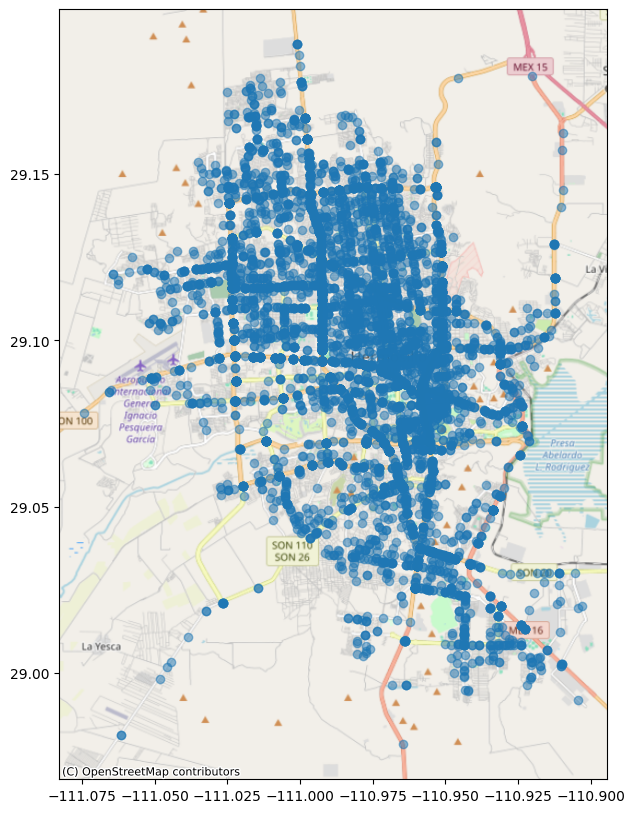

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

atus_urb[atus_urb['anio']==2021]\
    .plot(
    ax=ax, 
    alpha=0.5,  
)
add_basemap_to_ax(ax, atus_urb.crs)
plt.show()

El total de registros en la zona urbana de Hermosillo: 

In [29]:
len(atus_urb)

32730

Podemos eliminar las columnas redundantes {`edo`, `mpio`}: 

In [30]:
atus_urb.drop(columns=['edo', 'mpio'], inplace=True)

C:\Users\isaul\AppData\Local\Temp\ipykernel_1732\4158212017.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atus_urb.drop(columns=['edo', 'mpio'], inplace=True)


Gurdamos los datos en el directorio temporal:

In [31]:
atus_urb.to_file(temp_dir.joinpath("atus_hmo_urb.geojson"), driver='GeoJSON')

Las columnas {`anio`, `mes`, `dia`, `hora`, `minutos`} pueden combinarse en una sola columna tipo *timestamp*: 

In [32]:
atus_urb['datetime'] = pd.to_datetime(
    atus_urb['anio'].astype(str) + '-' +
    atus_urb['mes'].astype(str).str.zfill(2) + '-' +
    atus_urb['dia'].astype(str).str.zfill(2) + ' ' +
    atus_urb['hora'].astype(str).str.zfill(2) + ':' +
    atus_urb['minutos'].astype(str).str.zfill(2)
)
atus_urb.datetime.head()

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


117875   2021-01-01 14:55:00
117876   2021-01-01 15:20:00
117877   2021-01-01 22:30:00
117879   2021-01-02 15:52:00
117880   2021-01-02 17:58:00
Name: datetime, dtype: datetime64[ns]

### 2.1  Decodificación de variables categoricas

En lo que sigue se exploran las variables categóricas del conjunto de datos. El objetivo es **reempplazar sus valores numéricos por etiquetas descriptivas** según el [diccionario de datos](../data/raw/atus/atus_2022_shp/diccionario_de_datos/fd_bd_atus_georreferenciación.xlsx) proporcionado por el INEGI. 

Para cada variable se implementa una función que convierte la vairbale numérica en categorica usando el diccionario de datos y se prueba su funcionamiento. 

La variable `diasemana` reprecenta el día de la semana en la que ocurrio el accidente:

In [33]:
atus_urb.diasemana.unique()

array([5, 6, 7, 1, 2, 3, 4])

In [34]:
def decode_dia_semana(valor):
    dias = {
        1: "lunes", 2: "martes", 3: "miércoles", 4: "jueves",
        5: "viernes", 6: "sábado", 7: "domingo"
    }
    return dias.get(valor)

In [35]:
atus_urb['diasemana'] = atus_urb['diasemana'].apply(decode_dia_semana)
atus_urb.diasemana.unique()

c:\Users\isaul\Documents\repos\baches_accidentes\.venv\Lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


array(['viernes', 'sábado', 'domingo', 'lunes', 'martes', 'miércoles',
       'jueves'], dtype=object)

La variable `urbana` indica el tipo de zona urbana donde ocurrió el accidente:

Según el diccionario de datos: 

* 0 = Zona suburbana
* 1 = Intersección
* 2 = No intersección

In [37]:
atus_urb.urbana.unique()

array([1, 0, 2])

In [38]:
def decode_zona_urbana(valor):
    zonas = {0: "suburbana", 1: "intersección", 2: "no intersección"}
    return zonas.get(valor)

In [39]:
atus_urb['urbana'] = atus_urb['urbana'].apply(decode_zona_urbana)
atus_urb.urbana.unique()

array(['intersección', 'suburbana', 'no intersección'], dtype=object)

La variable `suburbana` describe el tipo de zona suburbana del accidente.

Según el diccionario:

* 0 = Urbana
* 1 = Camino rural
* 2 = Carretera estatal
* 3 = Otro camino

In [40]:
atus_urb.suburbana.unique()

array([0, 2, 1])

In [41]:
def decode_zona_suburbana(valor):
    zonas = {
        0: "urbana", 1: "camino rural",
        2: "carretera estatal", 3: "otro camino"
    }
    return zonas.get(valor)

In [42]:
atus_urb['suburbana'] = atus_urb['suburbana'].apply(decode_zona_suburbana)
atus_urb.suburbana.unique()

array(['urbana', 'carretera estatal', 'camino rural'], dtype=object)

La variable `tipaccid` identifica el tipo de accidente registrado.

De acuerdo con el diccionario:

* 1 = Colisión con vehículo automotor
* 2 = Atropellamiento
* 3 = Colisión con animal
* 4 = Colisión con objeto fijo
* 5 = Volcadura
* 6 = Caída de pasajero
* 7 = Salida del camino
* 8 = Incendio
* 9 = Colisión con ferrocarril
* 10 = Colisión con motocicleta
* 11 = Colisión con ciclista
* 12 = Otro

In [43]:
atus_urb.tipaccid.unique()

array([ 1, 10,  4,  2,  5, 11,  6,  7,  3, 12,  9])

In [44]:
def decode_tipo_accidente(valor):
    tipos = {
        0: "certificado cero",
        1: "colisión con vehículo automotor",
        2: "atropellamiento",
        3: "colisión con animal",
        4: "colisión con objeto fijo",
        5: "volcadura",
        6: "caída de pasajero",
        7: "salida del camino",
        8: "incendio",
        9: "colisión con ferrocarril",
        10: "colisión con motocicleta",
        11: "colisión con ciclista",
        12: "otro"
    }
    return tipos.get(valor)

In [45]:
atus_urb['tipaccid'] = atus_urb['tipaccid'].apply(decode_tipo_accidente)
atus_urb.tipaccid.unique()

array(['colisión con vehículo automotor', 'colisión con motocicleta',
       'colisión con objeto fijo', 'atropellamiento', 'volcadura',
       'colisión con ciclista', 'caída de pasajero', 'salida del camino',
       'colisión con animal', 'otro', 'colisión con ferrocarril'],
      dtype=object)

La variable `causaacci` indica la causa probable o presunta del accidente.

Según el diccionario:

* 1 = Conductor
* 2 = Peatón o pasajero
* 3 = Falla del vehículo
* 4 = Mala condición del camino
* 5 = Otra


In [46]:
atus_urb.causaacci.unique()

array([1, 2, 3])

In [47]:
def decode_causa_accidente(valor):
    causas = {
        1: "conductor", 2: "peatón/pasajero",
        3: "falla del vehículo", 4: "mala condición del camino", 5: "otra"
    }
    return causas.get(valor)

In [48]:
atus_urb['causaacci'] = atus_urb['causaacci'].apply(decode_causa_accidente)
atus_urb.causaacci.unique()

array(['conductor', 'peatón/pasajero', 'falla del vehículo'], dtype=object)

La variable `caparod` señala la condición de la superficie del camino.

Valores posibles:

* 1 = Pavimentada
* 2 = No pavimentada

In [49]:
atus_urb.caparod.unique()

array([1, 2])

In [50]:
def decode_capa_rodamiento(valor):
    capas = {1: "pavimentada", 2: "no pavimentada"}
    return capas.get(valor)

In [51]:
atus_urb['caparod'] = atus_urb['caparod'].apply(decode_capa_rodamiento)
atus_urb.caparod.unique()

array(['pavimentada', 'no pavimentada'], dtype=object)

La variable `sexo` representa el sexo del conductor presunto responsable.

Valores:

* 1 = Se fugó
* 2 = Hombre
* 3 = Mujer

In [52]:
atus_urb.sexo.unique()

array([3, 2, 1])

In [53]:
def decode_sexo(valor):
    sexos = {1: "se fugó", 2: "hombre", 3: "mujer"}
    return sexos.get(valor)

In [54]:
atus_urb['sexo'] = atus_urb['sexo'].apply(decode_sexo)
atus_urb.sexo.unique()

array(['mujer', 'hombre', 'se fugó'], dtype=object)

La variable `aliento` indica si el conductor presentaba aliento alcohólico.

Según el diccionario:

* 4 = Sí
* 5 = No
* 6 = Se ignora

In [55]:
atus_urb.aliento.unique()

array([5, 4, 6])

In [ ]:
def decode_aliento(valor):
    aliento = {4: "si", 5: "no", 6: "se ignora"}
    return aliento.get(valor)

La variable `cinturon` representa el uso del cinturón de seguridad.

De acuerdo con el diccionario:

* 7 = Sí
* 8 = No
* 9 = Se ignora

In [57]:
atus_urb.cinturon.unique()

array([8, 7, 9])

In [ ]:
def decode_cinturon(valor):
    cinturon = {7: "si", 8: "no", 9: "se ignora"}
    return cinturon.get(valor)

In [59]:
atus_urb['cinturon'] = atus_urb['cinturon'].apply(decode_cinturon)
atus_urb.cinturon.unique()

array(['no', 'sí', 'se ignora'], dtype=object)

La variable `clase` clasifica la gravedad del accidente.

Valores posibles:

* 1 = Fatal
* 2 = No fatal
* 3 = Solo daños

In [60]:
atus_urb.clase.unique()

array([3, 2, 1])

In [61]:
def decode_clase_accidente(valor):
    clases = {1: "fatal", 2: "no fatal", 3: "solo daños"}
    return clases.get(valor)

In [62]:
atus_urb['clase'] = atus_urb['clase'].apply(decode_clase_accidente)
atus_urb.clase.unique()

array(['solo daños', 'no fatal', 'fatal'], dtype=object)

Guardamos los resultados en el directorio temporal: 

In [63]:
atus_urb.to_file(temp_dir.joinpath("atus__hmo_urb_clean.geojson"), driver='GeoJSON')

## 3. Conclusiones 

El conunto de datos limpio posee la siguiente estructura: 

In [64]:
atus_urb.head()

,id,mes,anio,hora,minutos,dia,diasemana,urbana,suburbana,tipaccid,...,totheridos,clase,calle1,calle2,carretera,longitud,latitud,oid,geometry,datetime
117875,1006278-999-1,1,2021,14,55,1,viernes,intersección,urbana,colisión con vehículo automotor,...,0,solo daños,LEY FEDERAL DEL TRABAJO,ARIZONA,None,-110.97734,29.11893,117876,POINT (-110.97734 29.11893),2021-01-01 14:55:00
117876,1006278-999-2,1,2021,15,20,1,viernes,intersección,urbana,colisión con vehículo automotor,...,0,solo daños,SOLIDARIDAD,RICARDO VALENCIA Y SOUZA,None,-110.99451,29.13579,117877,POINT (-110.99451 29.13579),2021-01-01 15:20:00
117877,1006278-999-3,1,2021,22,30,1,viernes,intersección,urbana,colisión con vehículo automotor,...,0,solo daños,TERCERA DE WISTARIA,LÁZARO MERCADO,None,-111.01642,29.12439,117878,POINT (-111.01642 29.12439),2021-01-01 22:30:00
117879,1006278-999-6,1,2021,15,52,2,sábado,intersección,urbana,colisión con motocicleta,...,0,solo daños,SOLIDARIDAD,PASEO NORTE,None,-110.98266,29.08130,117880,POINT (-110.98266 29.0813),2021-01-02 15:52:00
117880,1006278-999-7,1,2021,17,58,2,sábado,intersección,urbana,colisión con vehículo automotor,...,1,no fatal,AGUSTÍN DE VILDOSOLA,REVOLUCIÓN,None,-110.95437,29.06065,117881,POINT (-110.95438 29.06065),2021-01-02 17:58:00


El conjunto de datos limpio de **accidentes de tránsito (ATUS)** conserva únicamente los registros **georreferenciados dentro de la zona urbana de Hermosillo**, delimitada mediante una *boundary box* definida en coordenadas geográficas.


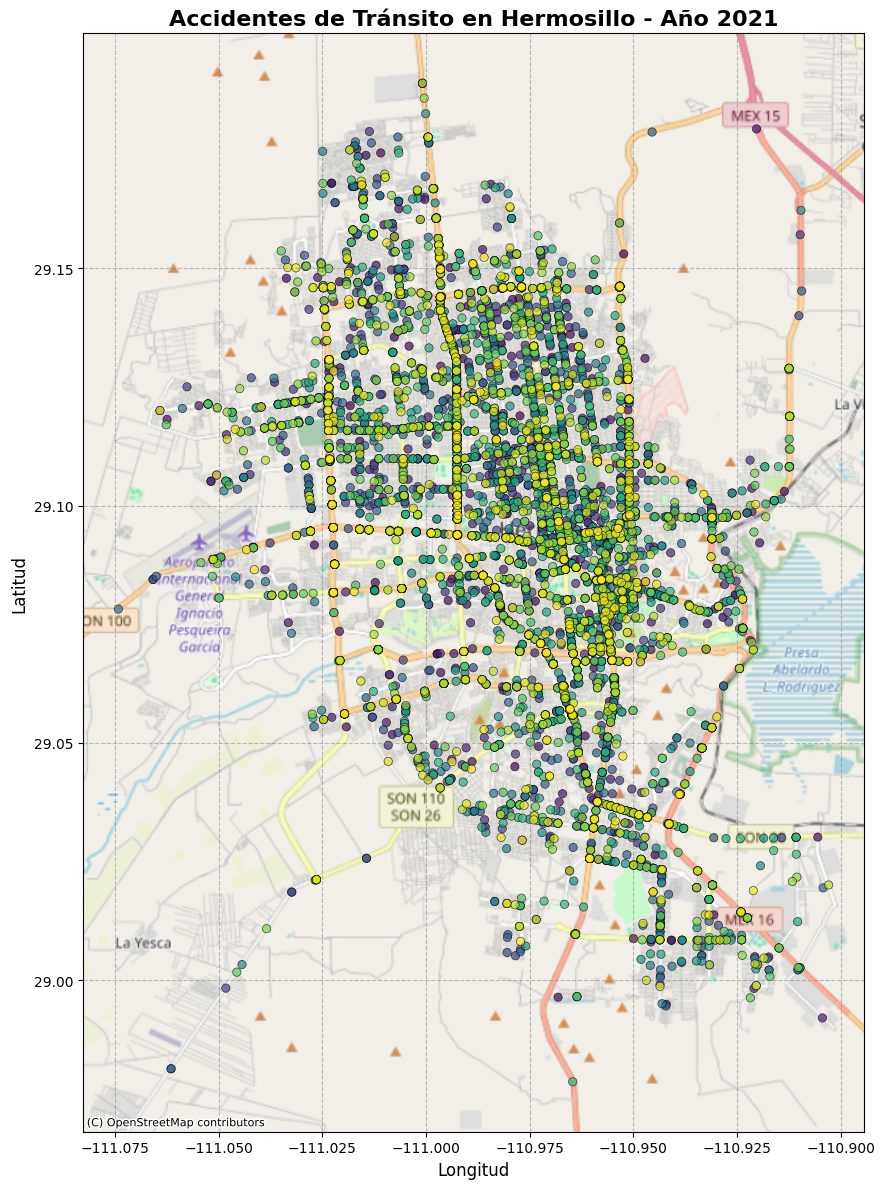

In [66]:
fig, ax = plt.subplots(figsize=(12, 12))

data_2021 = atus_urb[atus_urb['anio'] == 2021]

data_2021.plot(
    ax=ax,
    alpha=0.7,  
    edgecolor='k',  
    linewidth=0.5,  
    cmap='viridis'  
)

add_basemap_to_ax(ax, atus_urb.crs)

ax.set_title('Accidentes de Tránsito en Hermosillo - Año 2021', fontsize=16, fontweight='bold')
ax.set_xlabel('Longitud', fontsize=12)
ax.set_ylabel('Latitud', fontsize=12)

ax.set_facecolor('white')  
ax.grid(True, linestyle='--', color='gray', alpha=0.5) 

plt.tight_layout()
plt.show()


Durante el proceso de limpieza se realizaron las siguientes transformaciones principales:

* **Filtrado espacial** de los accidentes para conservar únicamente aquellos ocurridos dentro del área urbana.
* **Decodificación de variables categóricas**, reemplazando los valores numéricos por etiquetas descriptivas de acuerdo con el diccionario de datos del INEGI.
* **Eliminación de columnas redundantes** (como `edo` y `mpio`) y estandarización de nombres de variables.
* **Creación de la columna `datetime`**, combinando la fecha y hora del accidente para facilitar análisis temporales.


El resultado es un conjunto de datos **homogéneo, descriptivo y listo para análisis**, compatible con las demás fuentes del proyecto (*vialidades*, *colonias* y *clima*).

El proceso de limpieza descrito en esta libreta ha sido **automatizado** en el *script* [`src/clean_atus.py`](../src/clean_atus.py), garantizando su **reproducibilidad** e integración dentro del *pipeline* general del proyecto.